In [1]:
import warnings
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist
s = hist.tag.Slicer()

from coffea import util

import quad_fit_tools as qft

import os

In [2]:
wcstring = {}
wcstring['cHWtil'] = r'$\tilde{c}_{HW}$'
wcstring['cHW'] = r'$c_{HW}$'
wcstring['cHBtil'] = r'$\tilde{c}_{HB}$'
wcstring['cHB'] = r'$c_{HB}$'
wcstring['cHWBtil'] = r'$\tilde{c}_{HWB}$'
wcstring['cHWB'] = r'$c_{HWB}$'
wcstring['cHj1'] = r'$c_{Hj1}$'
wcstring['cHj3'] = r'$c_{Hj3}$'
wcstring['cHbox'] = r'$c_{Hbox}$'
wcstring['cHDD'] = r'$c_{HDD}$'
wcstring['cHd'] = r'$c_{Hd}$'
wcstring['cHu'] = r'$c_{Hu}$'
wcstring['cHudRe'] = r'Re($c_{Hud}$)'
wcstring['cHudIm'] = r'Im($c_{Hud}$)'
wcstring['cdBRe'] = r'Re($c_{dB}$)'
wcstring['cdBIm'] = r'Im($c_{dB}$)'
wcstring['cuBRe'] = r'Re($c_{uB}$)'
wcstring['cuBIm'] = r'Im($c_{uB}$)'
wcstring['cuWRe'] = r'Re($c_{uW}$)'
wcstring['cuWIm'] = r'Im($c_{uW}$)'
wcstring['cdWRe'] = r'Re($c_{dW}$)'
wcstring['cdWIm'] = r'Im($c_{dW}$)'
wcstring['cutbd1Im'] = r'???'

for x in wcstring.keys():
    print(x)

cHWtil
cHW
cHBtil
cHB
cHWBtil
cHWB
cHj1
cHj3
cHbox
cHDD
cHd
cHu
cHudRe
cHudIm
cdBRe
cdBIm
cuBRe
cuBIm
cuWRe
cuWIm
cdWRe
cdWIm
cutbd1Im


In [3]:
smpoint = {}
for x in wcstring.keys():
    smpoint[x] = 0
print(smpoint)

def reweight(myhist, wc, wcval, rwpoint = smpoint):

    wcbins = [myhist.axes[myhist.axes.name.index('wc')].bin(i) for i in range(0,myhist.axes[myhist.axes.name.index('wc')].size)]
    
    points = {}
    for p in wcbins:

        points[p] = rwpoint.copy()

        #for x in wcstring.keys():
        #    if x+"=" in p:
        #        points[p][x] = float(p.split(x+"=")[1].split(",")[0])

        if "SM" in p:
            continue

        for x in p.split(","):
            v = x.split("=")
            points[p][v[0]] = float(v[1])

    from functools import reduce
    parameters = list(rwpoint.keys()) #sorted(reduce(set.union, (set(keys) for keys in points), set()))
    #print(parameters)
    
    npar = len(parameters)
    ntri = npar*(npar+1)//2
    if len(points) < ntri:
        print(f"Have {len(points)} reweight points for {npar} paramteters. Need at least {ntri}")

    coefmap = np.zeros((len(points), ntri))

    for i, p in enumerate(points):
        coefvec = np.zeros(npar)
        # implicit cSM=0
        #coefvec[parameters.index("cInit")] = 0
        
        for name, val in points[p].items():
            coefvec[parameters.index(name)] = val
        coeftri = np.multiply.outer(coefvec, coefvec)[np.tril_indices(npar)]
        coefmap[i] = coeftri

    x, residuals, rank, s = np.linalg.lstsq(coefmap, myhist.values().T, rcond=None)
    scaling = np.zeros((myhist.values().shape[0], npar, npar))
    for k, (i, j) in enumerate(zip(*np.tril_indices(npar))):
        scaling[:, i, j] += x[k] * 0.5
        scaling[:, j, i] += x[k] * 0.5

    def weightfor(coef):
        return np.einsum("i,eij,j->e", coef, scaling, coef)

    coefvec = np.zeros(npar)
    #coefvec[parameters.index("cInit")] = 0
    coefvec[parameters.index(wc)] = wcval

    return weightfor(coefvec)

{'cHWtil': 0, 'cHW': 0, 'cHBtil': 0, 'cHB': 0, 'cHWBtil': 0, 'cHWB': 0, 'cHj1': 0, 'cHj3': 0, 'cHbox': 0, 'cHDD': 0, 'cHd': 0, 'cHu': 0, 'cHudRe': 0, 'cHudIm': 0, 'cdBRe': 0, 'cdBIm': 0, 'cuBRe': 0, 'cuBIm': 0, 'cuWRe': 0, 'cuWIm': 0, 'cdWRe': 0, 'cdWIm': 0, 'cutbd1Im': 0}


In [4]:
samp1 = "VBF_SMEFTsim_topU3l_NP1"
output1 = util.load("coffea/"+samp1+".coffea")

samp2 = "VBF_SMEFTsim_topU3l_NP1_start1"
output2 = util.load("coffea/"+samp2+".coffea")

In [5]:
h1 = output1['hpt']
h2 = output2['hpt']

In [29]:
def plot_with_ratio(wc, wcval, name, h1in, h2in, din, y0=[], y1=[], y2=[], rebin=1):
    fig, ax = plt.subplots(3,1,sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(10,12))
    fig.subplots_adjust(hspace=0.1)
    
    var = h1in.axes[0].name
    hist1 = h1in[{var:s[::hist.rebin(rebin)]}]
    hist2 = h2in[{var:s[::hist.rebin(rebin)]}]
    hist3 = din[{var:s[::hist.rebin(rebin)]}]
    
    bin_width = hist1.axes[0].widths[0]
    
    sm = hist1[{'wc':'SM'}].values()/(10**6)/bin_width
    sm_err = np.sqrt(hist1[{'wc':'SM'}].variances())/(10**6)/bin_width

    hist1_norm = reweight(hist1, wc, wcval)/(10**6)/bin_width
    hist1_norm_err = np.sqrt(hist1[{'wc':'SM'}].variances())/(10**6)/bin_width

    #rwpoint = smpoint
    #'cHB=1,cHBtil=1,cHDD=1,cHW=1,cHWB=1,cHWBtil=1,cHWtil=1,cHbox=1,cHd=1,cHj1=1,cHj3=1,cHu=1,cHudIm=1,cHudRe=1,cdBIm=1,cdBRe=1,cdWRe=1,cuBIm=1,cuBRe=1,cuWIm=1,cuWRe=1,cutbd1Im=1'

    hist2_norm = reweight(hist2, wc, wcval)/(10**6)/bin_width
    hist2_norm_err = np.sqrt(hist2[{'wc':'SM'}].variances())/(10**6)/bin_width

    d_norm = hist3[{'wc':'SM'}].values()/(10**6)/bin_width
    d_norm_err = np.sqrt(hist3[{'wc':'SM'}].variances())/(10**6)/bin_width
    
    the_bins = hist1[{'wc':'SM'}].axes[0].edges
    bin_centers = the_bins[:-1] + 0.5*np.diff(the_bins)
    
    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=sm,
               label='SM',
               histtype='step',
               color='black',
               lw=2,
               linestyle='dotted',
               )  
    ax[0].errorbar(bin_centers, sm, yerr=sm_err, linestyle='',color='black',lw=2)
    
    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_norm,
               label='from 0',
               histtype='step',
               color='tab:red',
               lw=2
               )        
    ax[0].errorbar(bin_centers, hist1_norm, yerr=hist1_norm_err, linestyle='',color='tab:red',lw=2)
    
    #ax[0].hist(the_bins[:-1],
    #           bins=the_bins,
    #           weights=hist2_norm,
    #           label='from 1',
    #           histtype='step',
    #           color='tab:blue',
    #           lw=2
    #           )   
    #ax[0].errorbar(bin_centers, hist2_norm, yerr=hist2_norm_err, linestyle='',color='tab:blue',lw=2)

    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=d_norm,
               label='Simulated '+wcstring[wc]+'=1',
               histtype='step',
               color='tab:orange',
               lw=2
               )   
    ax[0].errorbar(bin_centers, d_norm, yerr=d_norm_err, linestyle='',color='tab:orange',lw=2)
       
    # Ratio panel
    hist1_rat = np.divide(hist1_norm,sm)#*rw[{'wc':'SM',var:sum}].value
    hist1_rat_err = np.divide(hist1_norm_err,sm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat = np.divide(hist2_norm,sm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat_err = np.divide(hist2_norm_err,sm)#*rw[{'wc':'SM',var:sum}].value
        
    ax[1].hist(the_bins[:-1],
               bins=the_bins,
               weights=np.ones(len(the_bins)-1),
               histtype='step',
               color='black',
               lw=2)
        
    ax[1].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_rat,
               histtype='step',color='tab:red',
               lw=2
               )        
    ax[1].errorbar(bin_centers, hist1_rat, yerr=hist1_rat_err, linestyle='',color='tab:red',lw=2)
        
    #ax[1].hist(the_bins[:-1],
    #           bins=the_bins,
    #           weights=hist2_rat,
    #           histtype='step',
    #           color='tab:blue',
    #           lw=2
    #           )   
    #ax[1].errorbar(bin_centers, hist2_rat, yerr=hist2_rat_err, linestyle='',color='tab:blue',lw=2)

    # Second ratio panel
    hist1_rat2 = np.divide(hist1_norm,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist1_rat2_err = np.divide(hist1_norm_err,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat2 = np.divide(hist2_norm,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat2_err = np.divide(hist2_norm_err,d_norm)#*rw[{'wc':'SM',var:sum}].value
        
    ax[2].hist(the_bins[:-1],
               bins=the_bins,
               weights=np.ones(len(the_bins)-1),
               histtype='step',
               color='tab:orange',
               lw=2)
        
    ax[2].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_rat2,
               histtype='step',
               color='tab:red',
               lw=2
               )        
    ax[2].errorbar(bin_centers, hist1_rat2, yerr=hist1_rat2_err, linestyle='',color='tab:red',lw=2)
      
    #ax[2].hist(the_bins[:-1],
    #           bins=the_bins,
    #           weights=hist2_rat2,
    #           histtype='step',
    #           color='tab:blue',
    #           lw=2
    #           )        
    #ax[2].errorbar(bin_centers, hist2_rat2, yerr=hist2_rat2_err, linestyle='',color='tab:blue',lw=2)

    ax[0].set_ylabel(name,fontsize=24)
    if 'GeV' in h1.axes[0].label:
        ax[0].set_yscale('log')
        ax[0].set_xlim(0,700)
    elif 'eta' in h1.axes[0].label:
        ax[0].set_xlim(-6,6)
    elif 'phi' in h1.axes[0].label:
        ax[0].set_xlim(-3.14,3.14)
            
    textstr = 'VBF H'
    ax[0].text(0.02, 1.07, textstr, transform=ax[0].transAxes, fontsize=24,
        verticalalignment='top', weight="bold")
        
    ax[1].set_ylabel('Ratio to\nSM',fontsize=24,multialignment='center')
    #ax[1].set_ylim(0.5,2)
    #ax[2].set_ylabel('Ratio to\nsim. '+wcstring[wc]+'='+str(int(wcval)),fontsize=24,multialignment='center')
    #ax[2].set_xlabel(h1.axes[0].label,fontsize=24)
    
    if len(y0) == 2:
        ax[0].set_ylim(y0)
    else:
        ax[0].set_ylim([10**-7,10**-1])
    if len(y1) == 2:
        ax[1].set_ylim(y1)
    else:
        ax[1].set_ylim([1,10])
    if len(y2) == 2:
        ax[2].set_ylim(y2)
    else:
        ax[2].set_ylim([0,10])
    
    fig.legend(frameon=False, fontsize=20, bbox_to_anchor=(0.9,0.88))
    
    plotdir = "noteplots/"+wc+"/"
    #if not os.path.exists(plotdir):
    #    os.mkdir(plotdir)
    #fig.savefig(plotdir+"overlay_"+var+"_"+wc+str(wcval)+".png",bbox_inches='tight')
    #fig.savefig(plotdir+"overlay_"+var+"_"+wc+str(wcval)+".pdf",bbox_inches='tight')
    

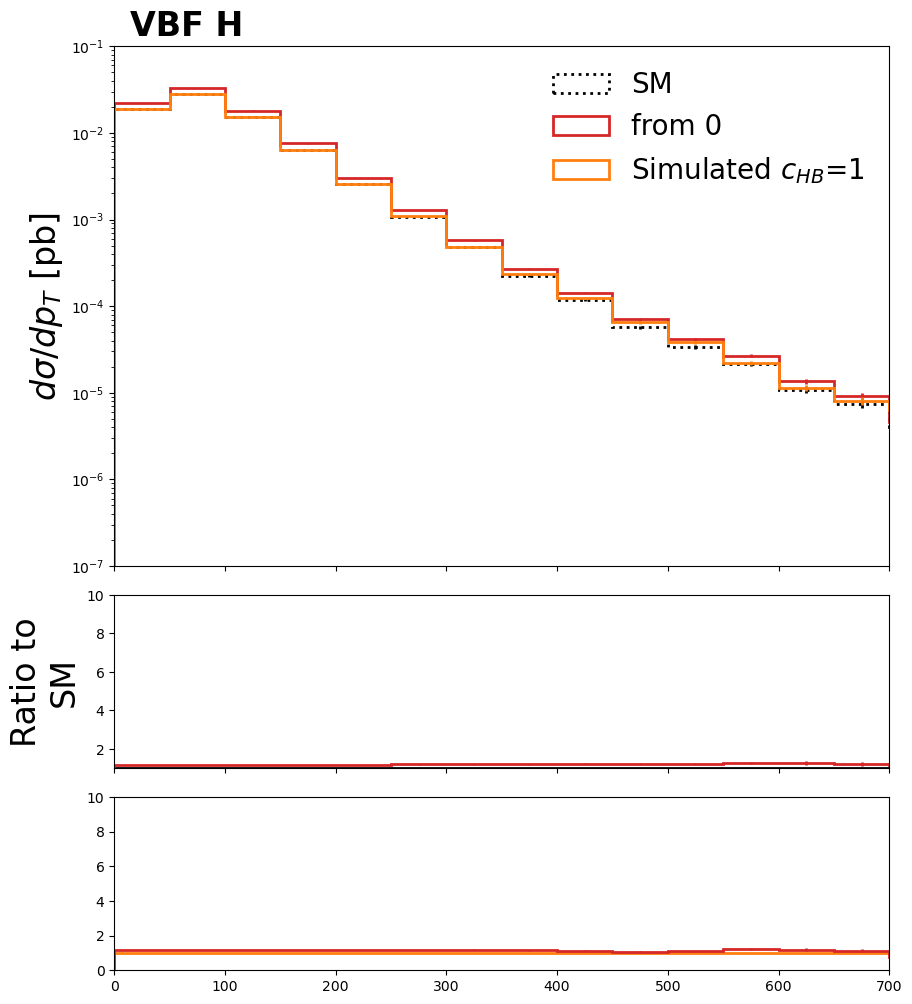

In [30]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHB"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHB', 1, name, h1, h2, d, rebin=10)

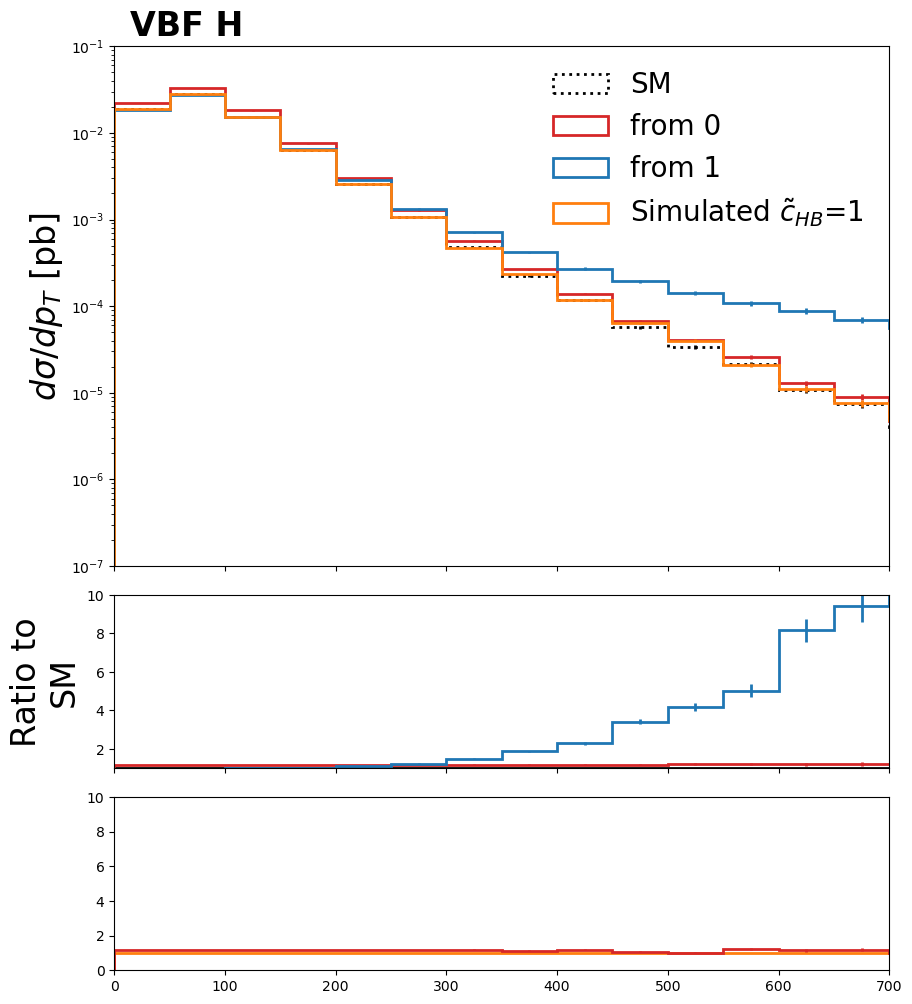

In [8]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHBtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHBtil', 1, name, h1, h2, d, rebin=10)

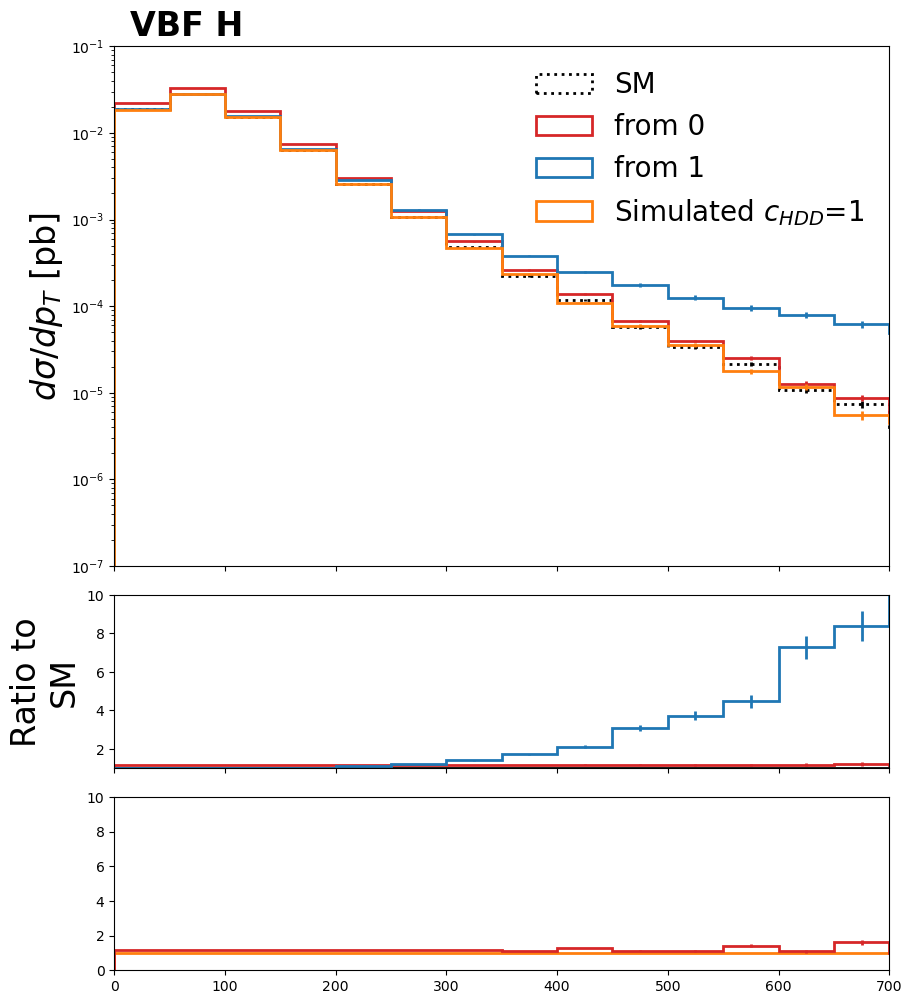

In [9]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHDD"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHDD', 1, name, h1, h2, d, rebin=10)

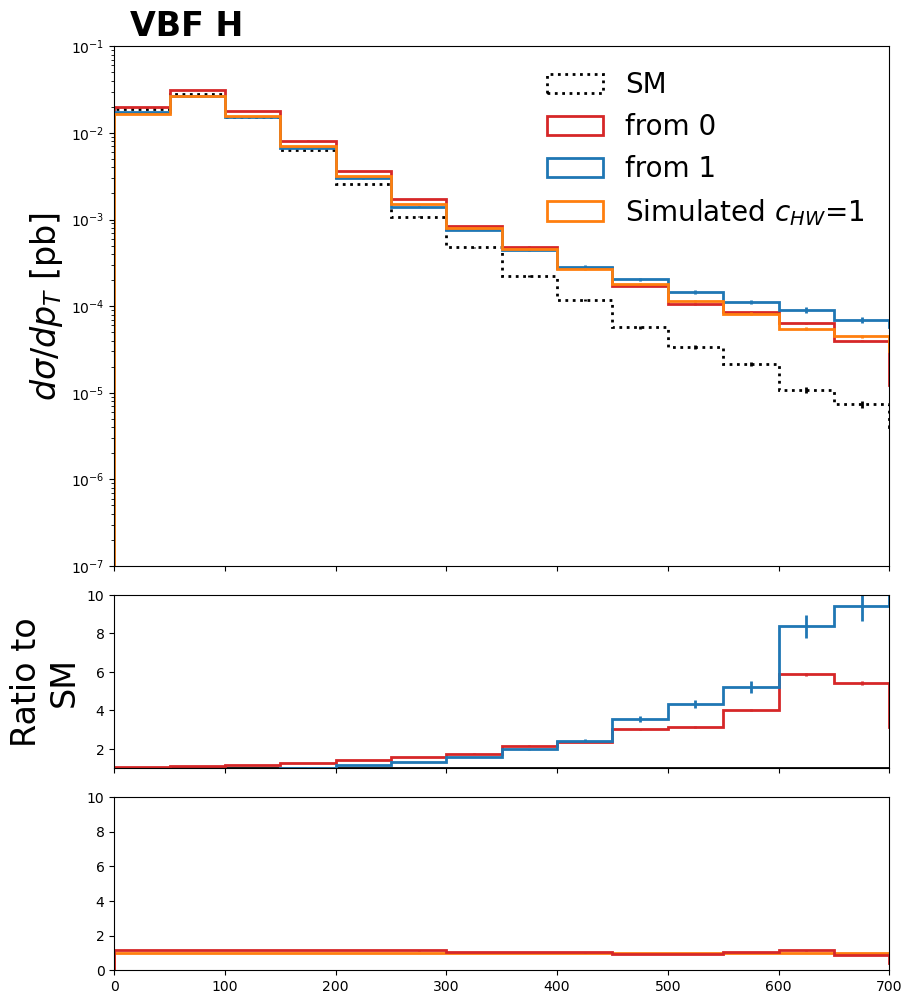

In [10]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHW"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHW', 1, name, h1, h2, d, rebin=10)

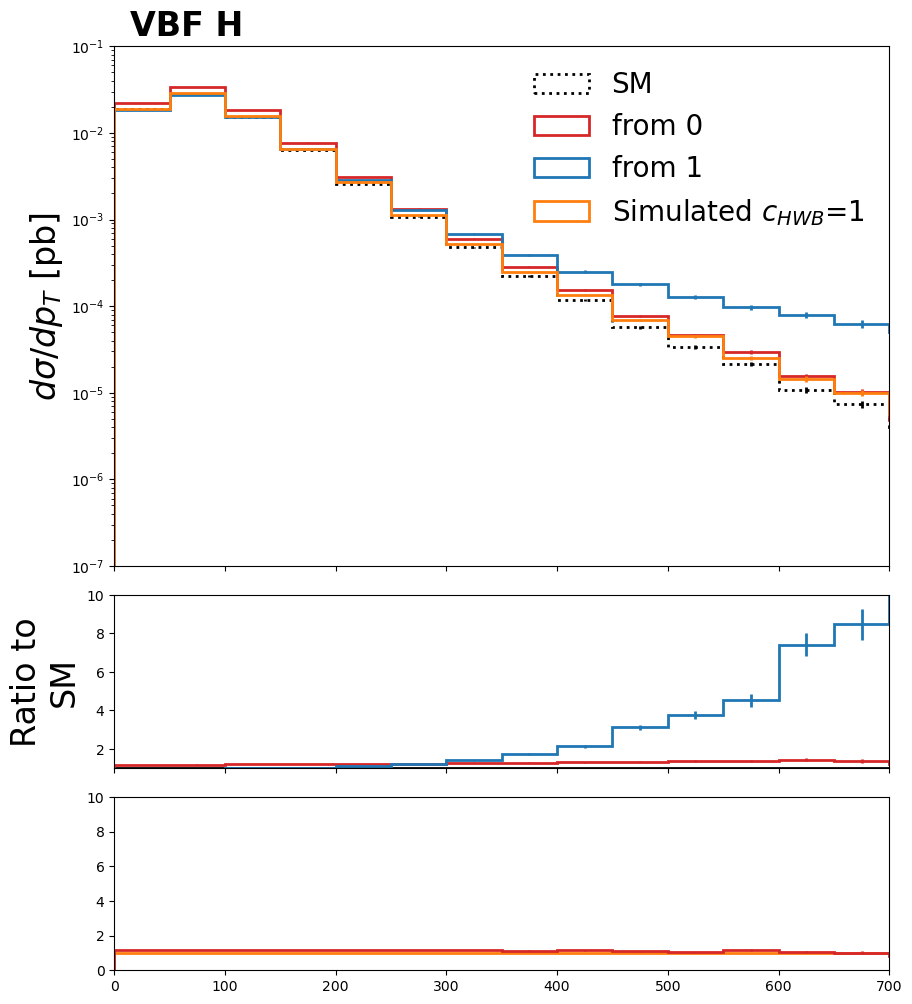

In [11]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWB"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWB', 1, name, h1, h2, d, rebin=10)

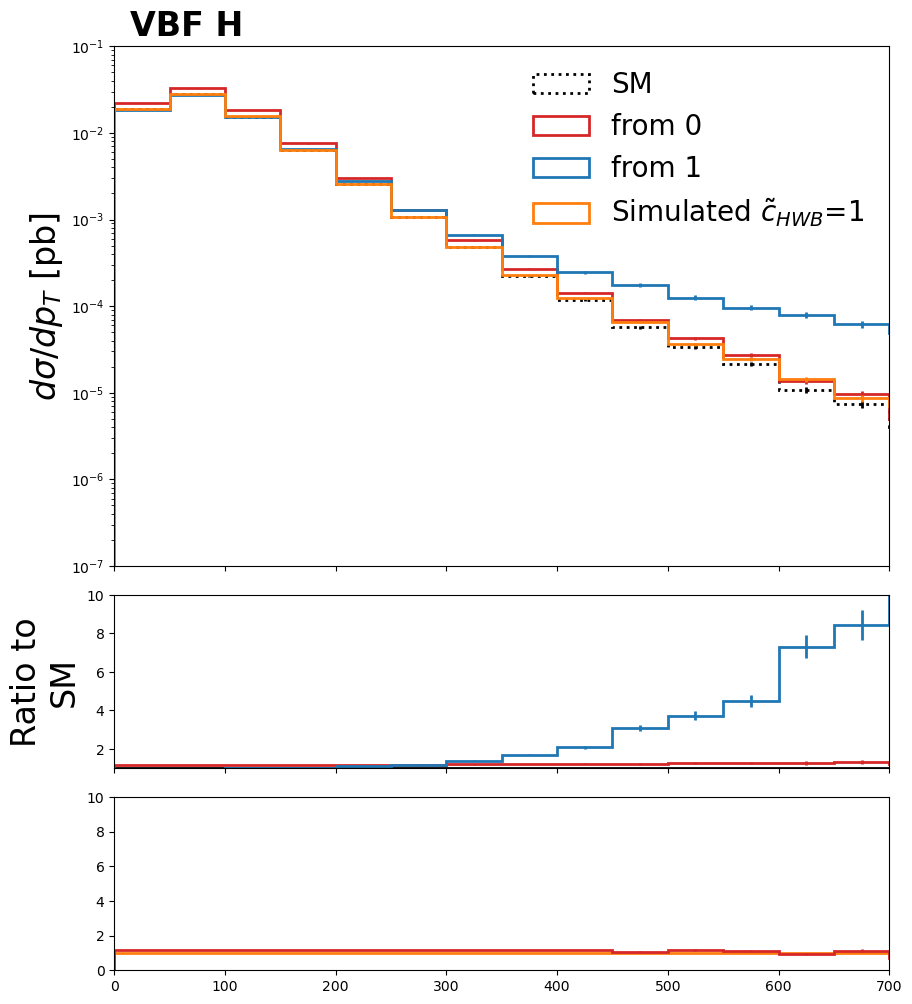

In [12]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWBtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWBtil', 1, name, h1, h2, d, rebin=10)

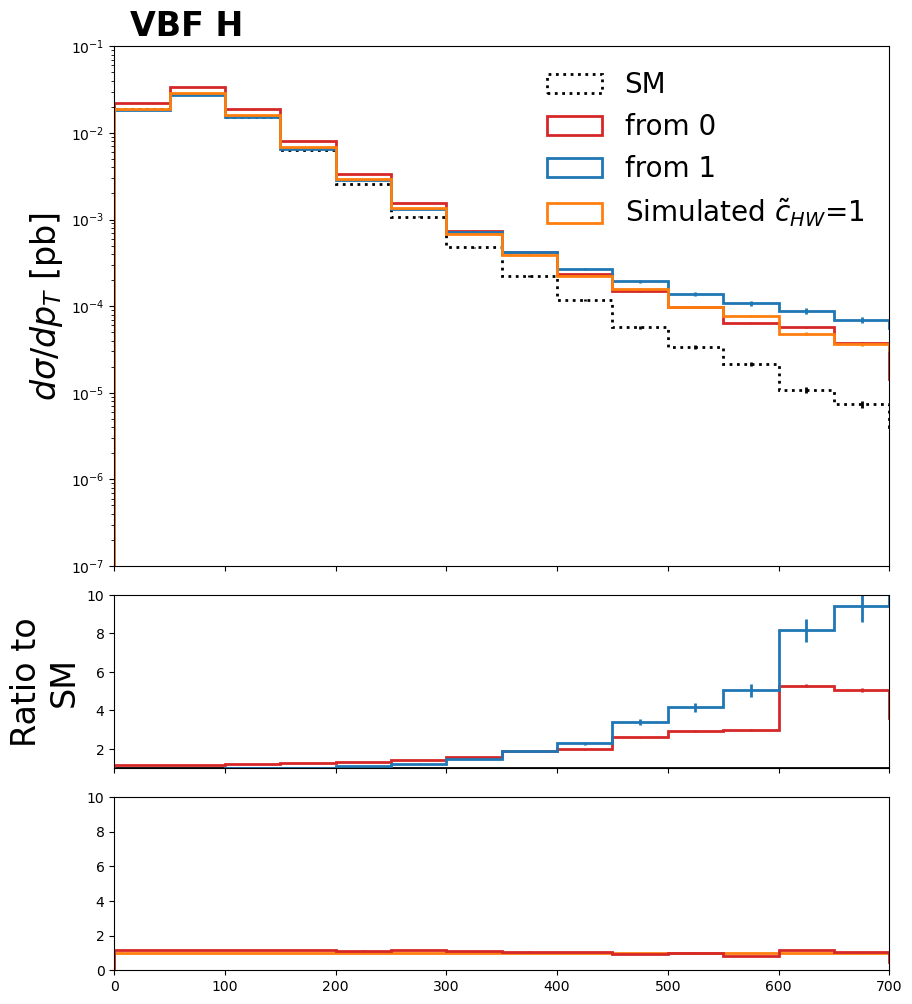

In [13]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWtil', 1, name, h1, h2, d, rebin=10)

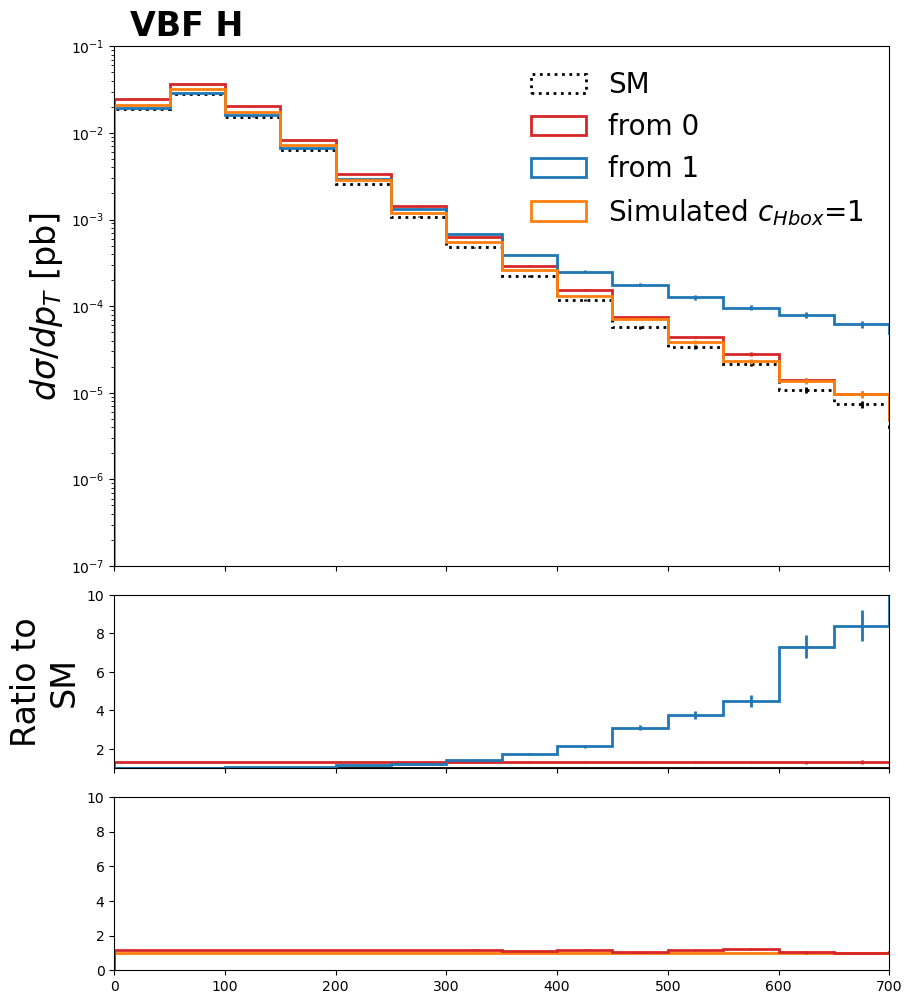

In [14]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHbox"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']


plot_with_ratio('cHbox', 1, name, h1, h2, d, rebin=10)

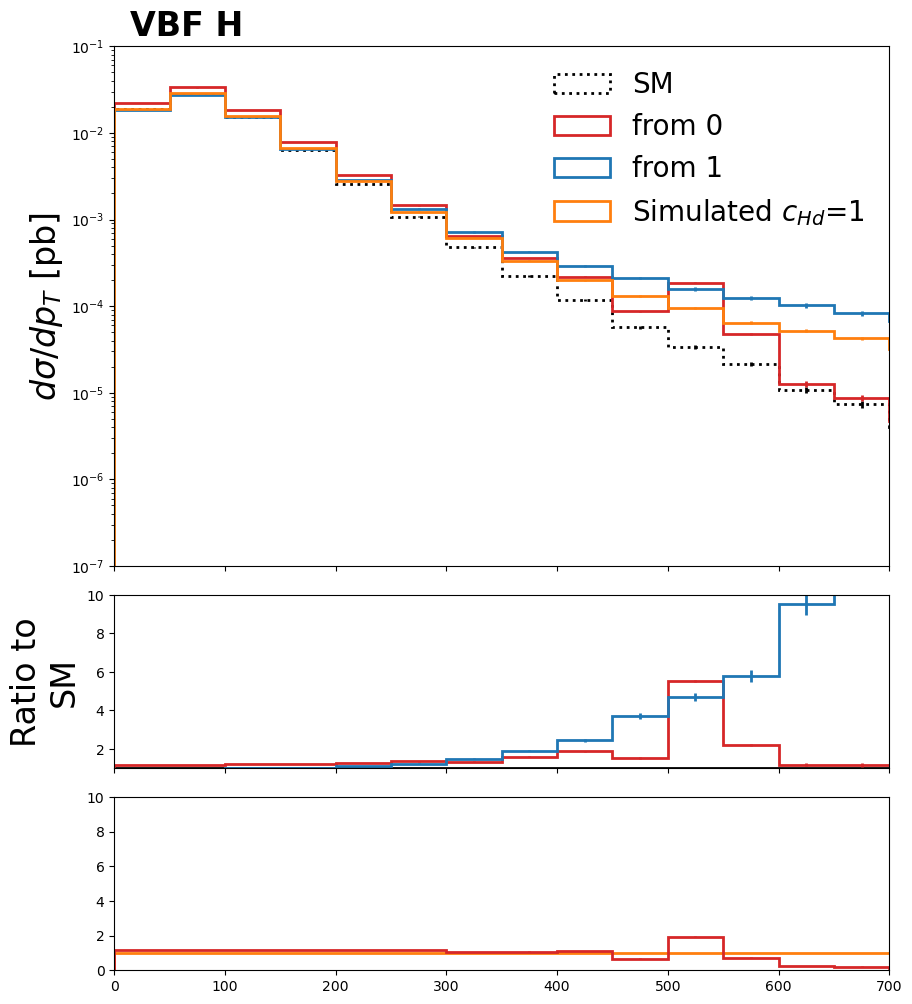

In [15]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHd"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHd', 1, name, h1, h2, d, rebin=10)

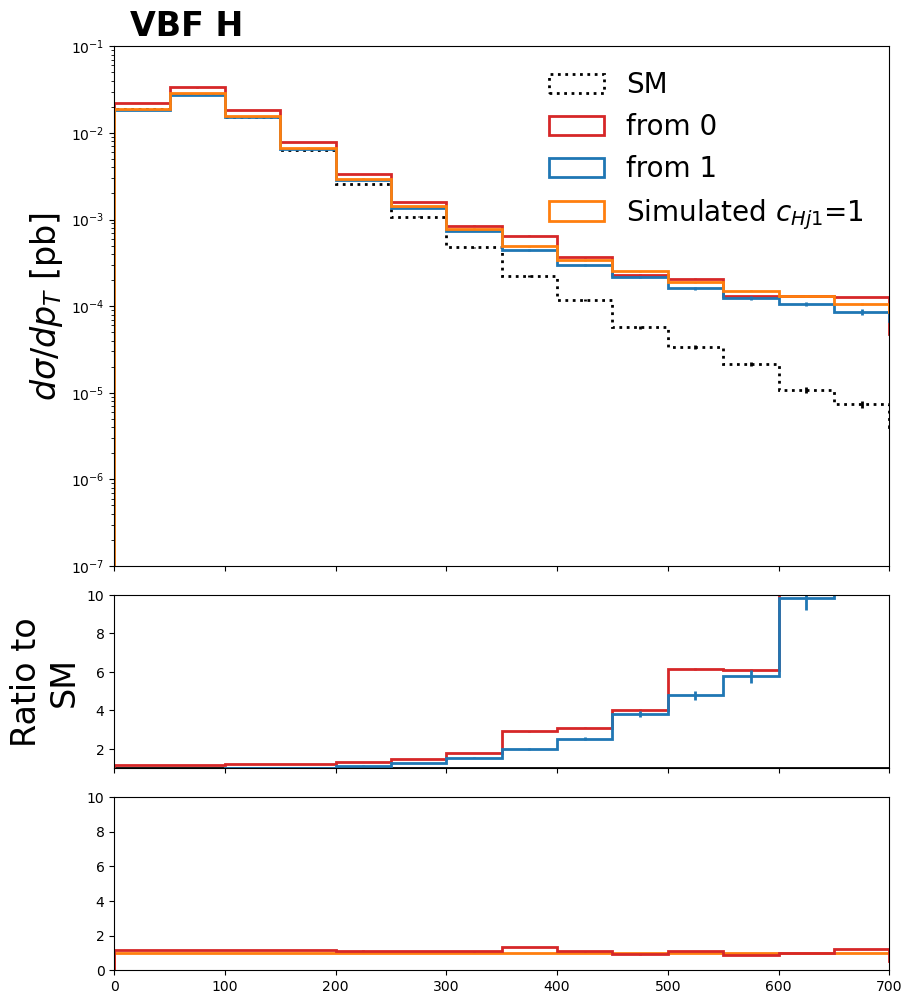

In [16]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHj1"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHj1', 1, name, h1, h2, d, rebin=10)

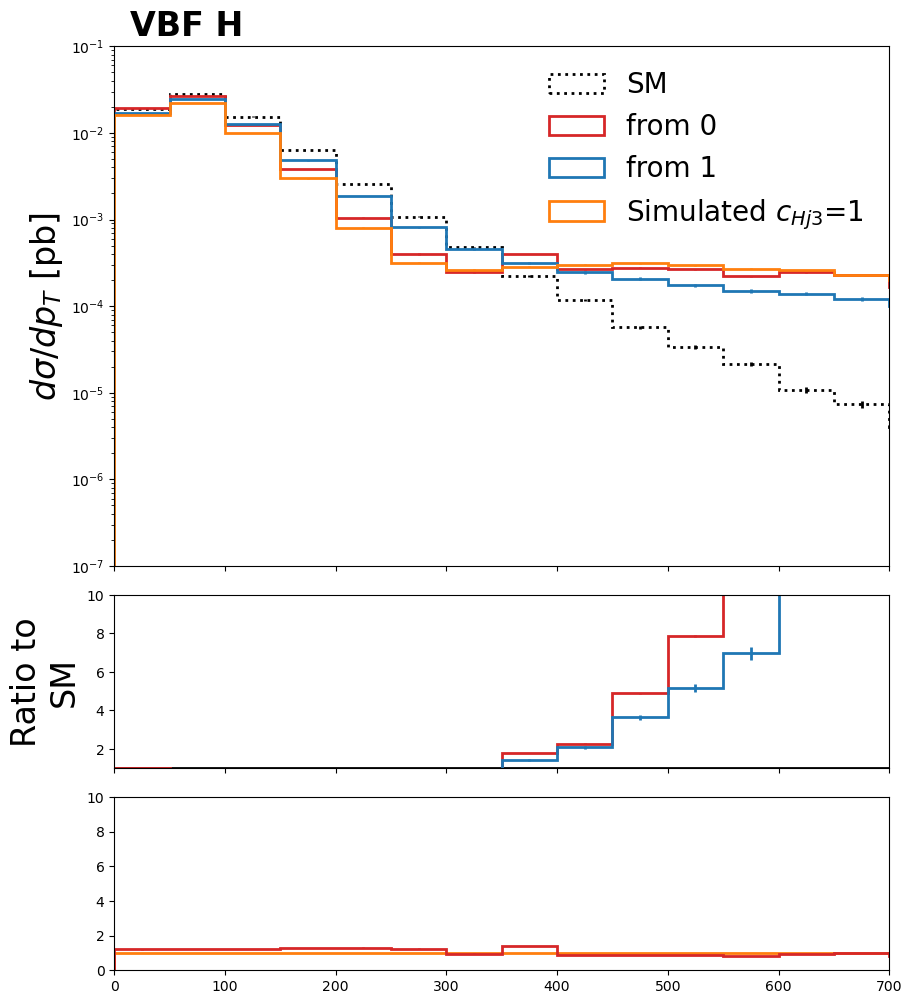

In [17]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHj3"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHj3', 1, name, h1, h2, d, rebin=10)

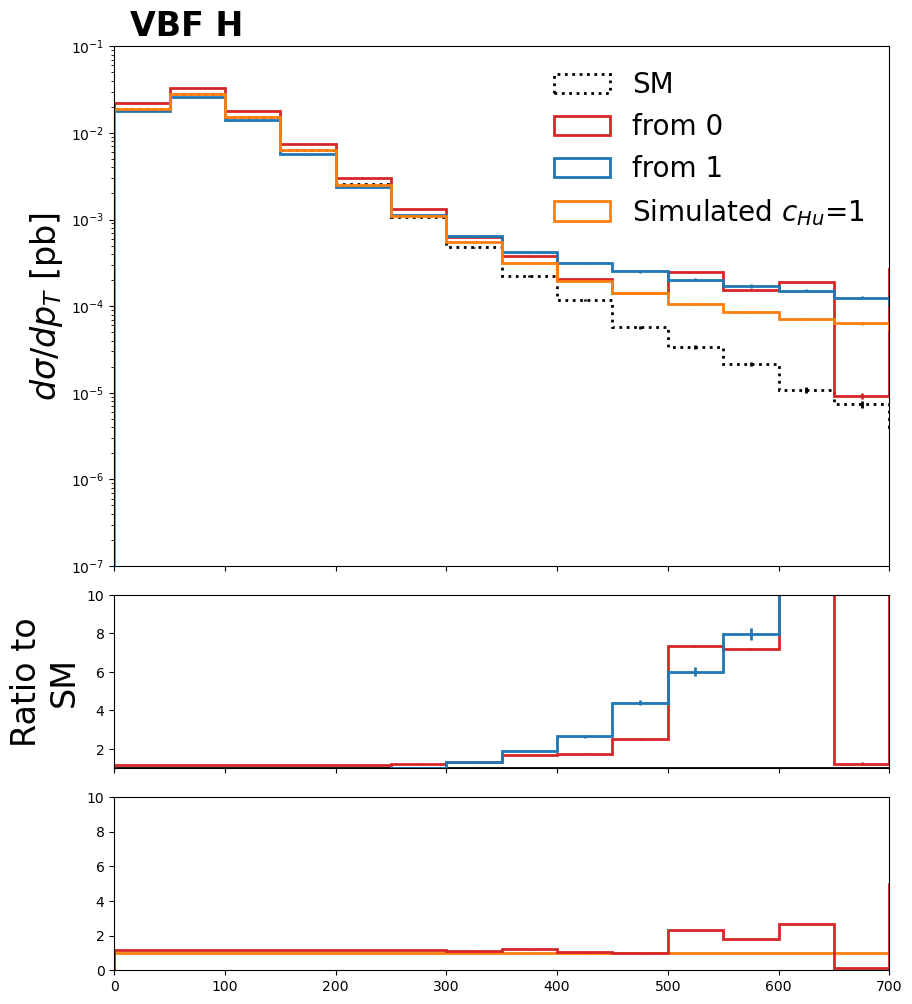

In [18]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHu"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHu', 1, name, h1, h2, d, rebin=10)

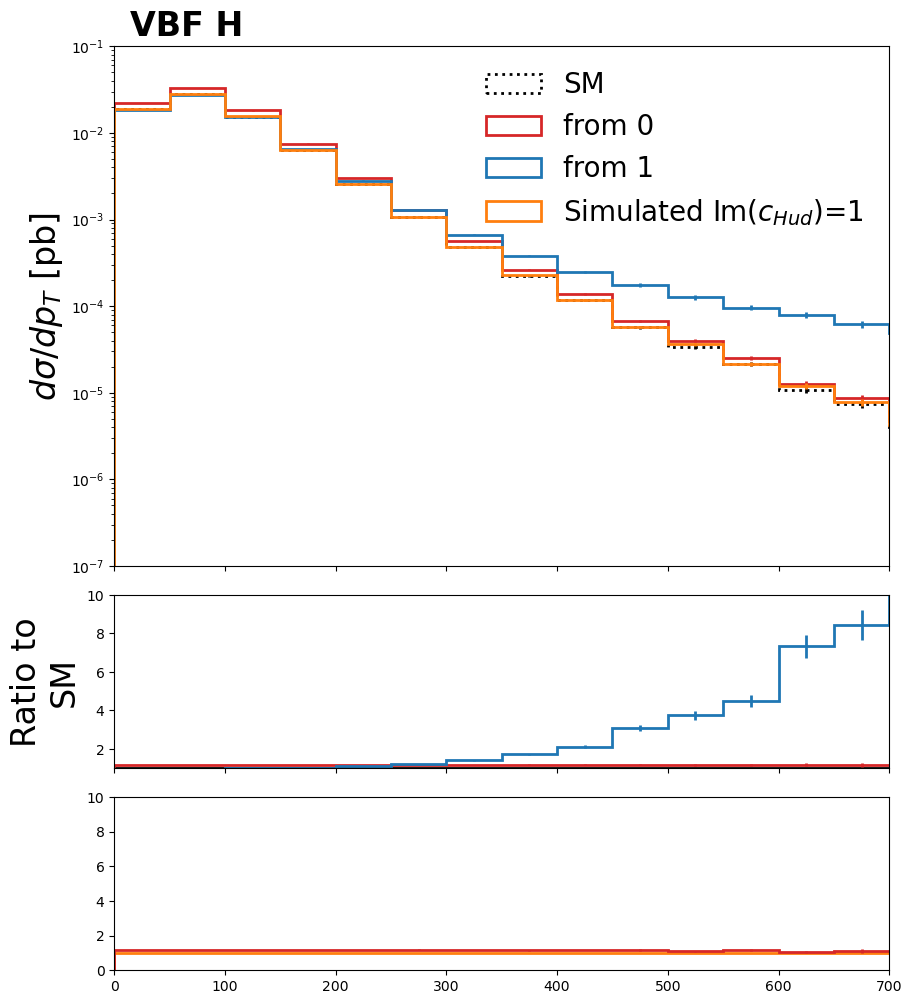

In [19]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHudIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHudIm', 1, name, h1, h2, d, rebin=10)

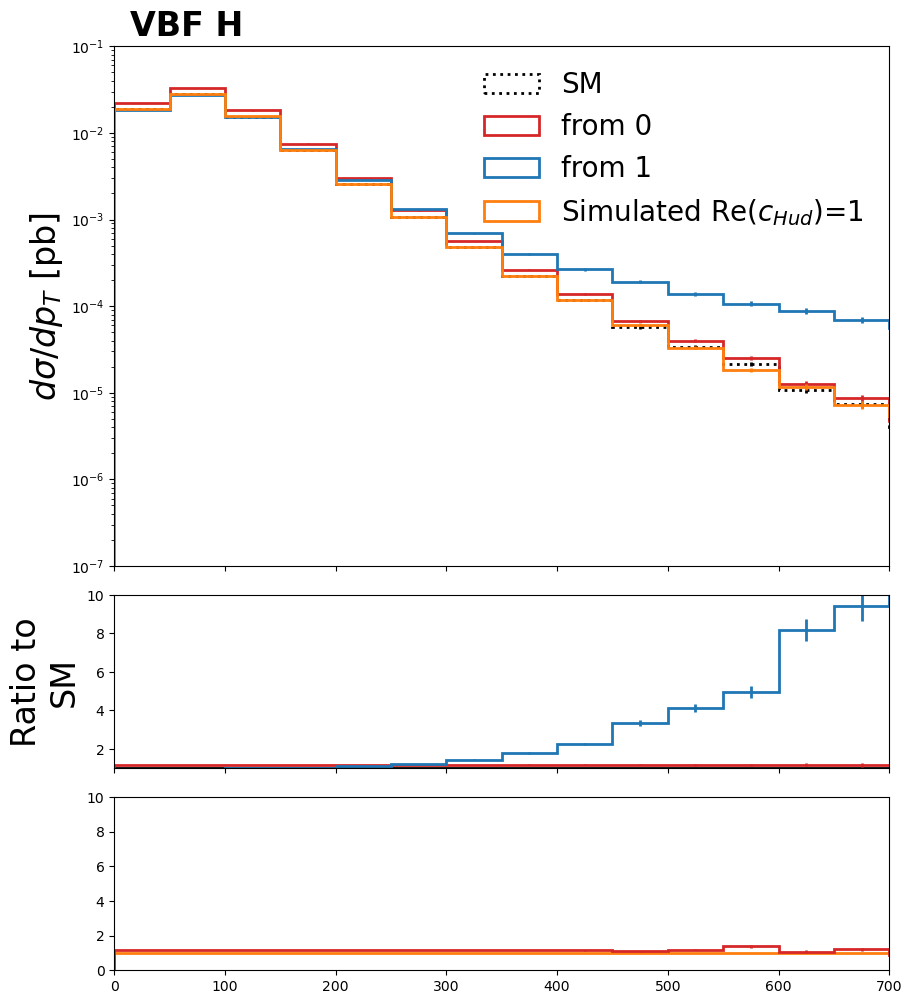

In [20]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHudRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHudRe', 1, name, h1, h2, d, rebin=10)

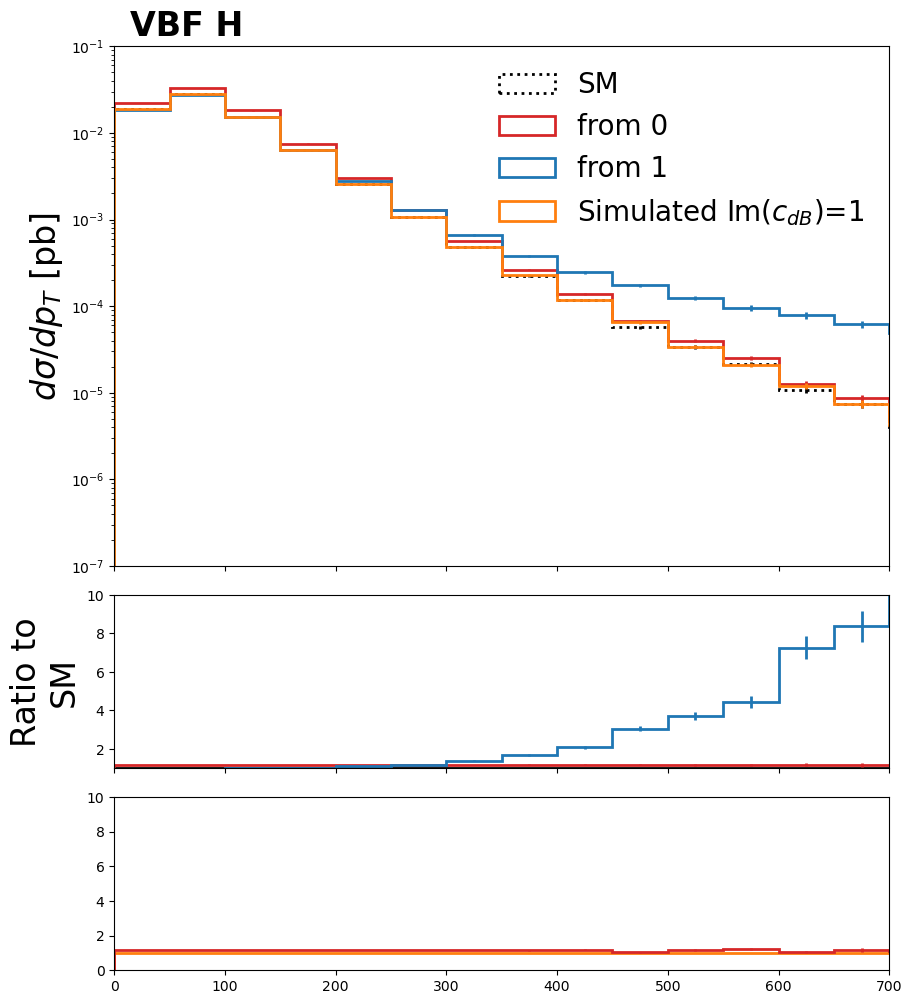

In [21]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdBIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdBIm', 1, name, h1, h2, d, rebin=10)

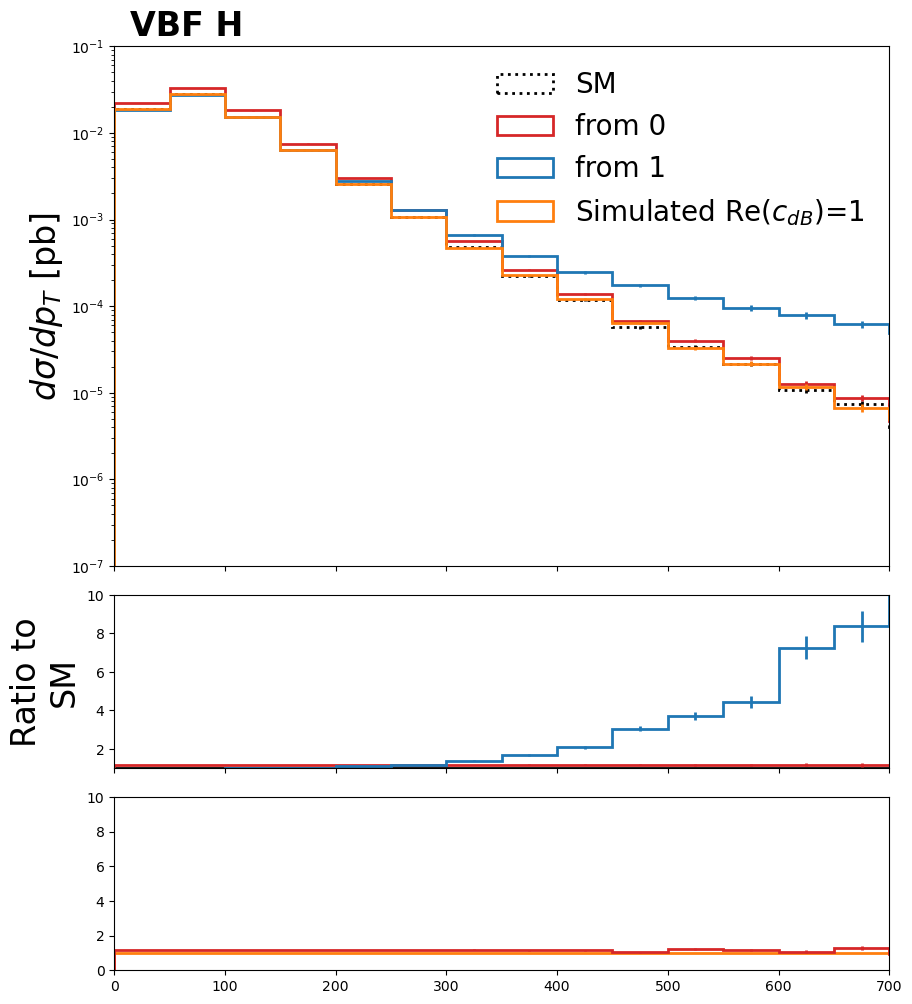

In [22]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdBRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdBRe', 1, name, h1, h2, d, rebin=10)

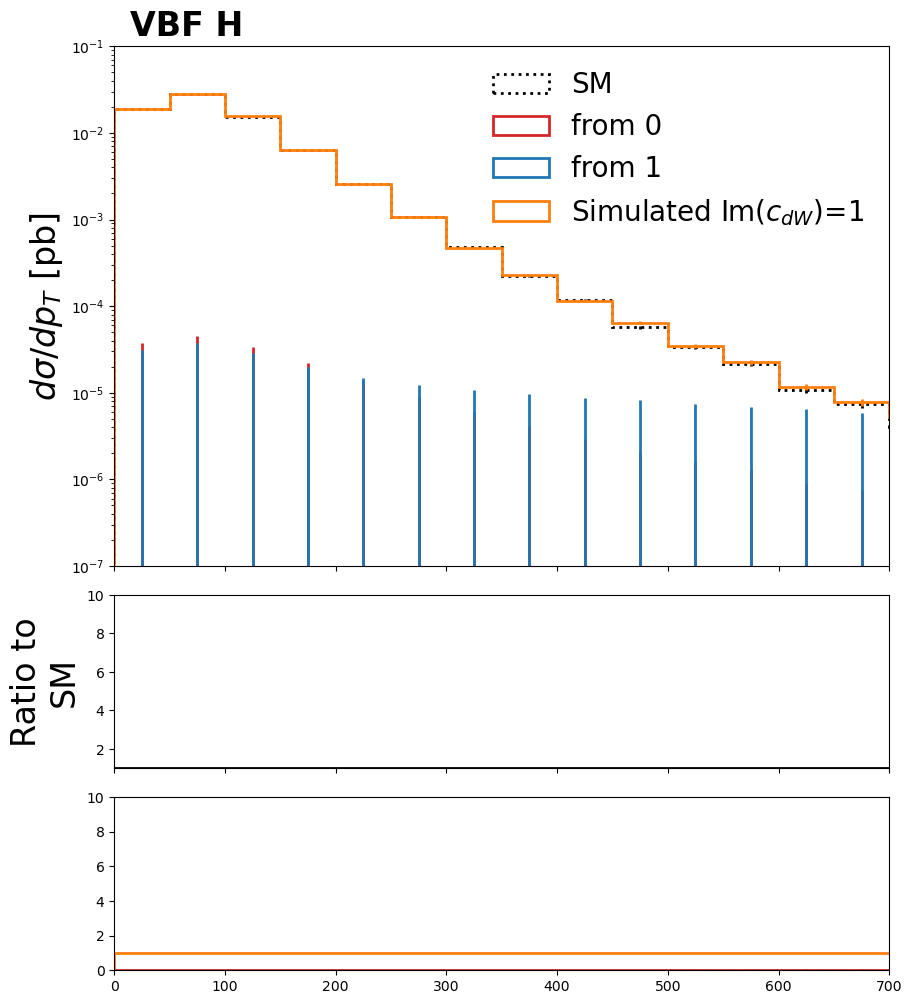

In [23]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdWIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdWIm', 1, name, h1, h2, d, rebin=10)

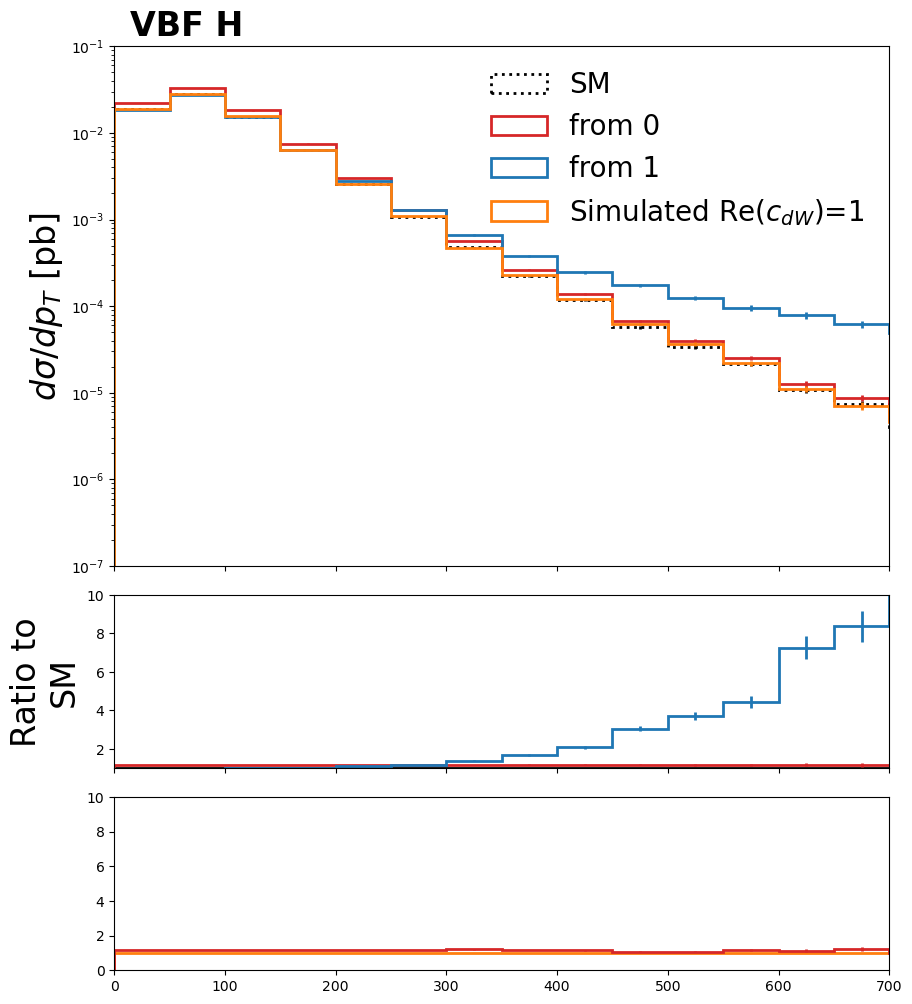

In [24]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdWRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdWRe', 1, name, h1, h2, d, rebin=10)

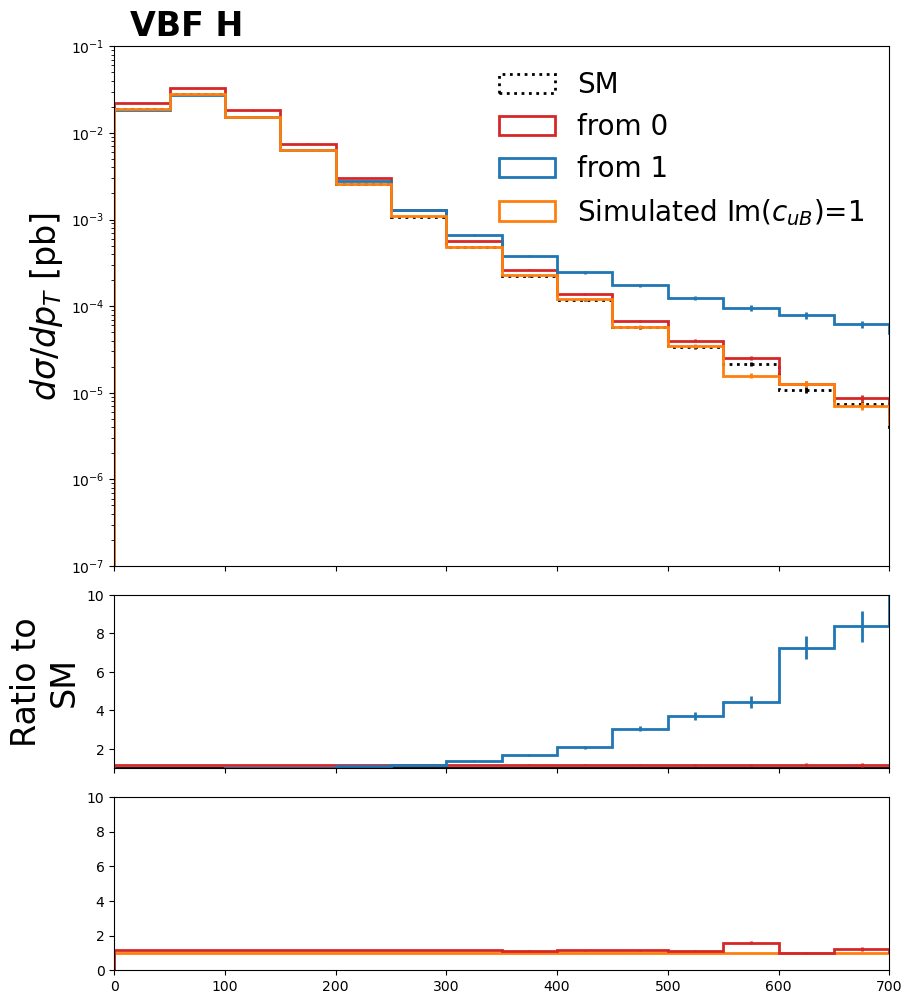

In [25]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuBIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuBIm', 1, name, h1, h2, d, rebin=10)

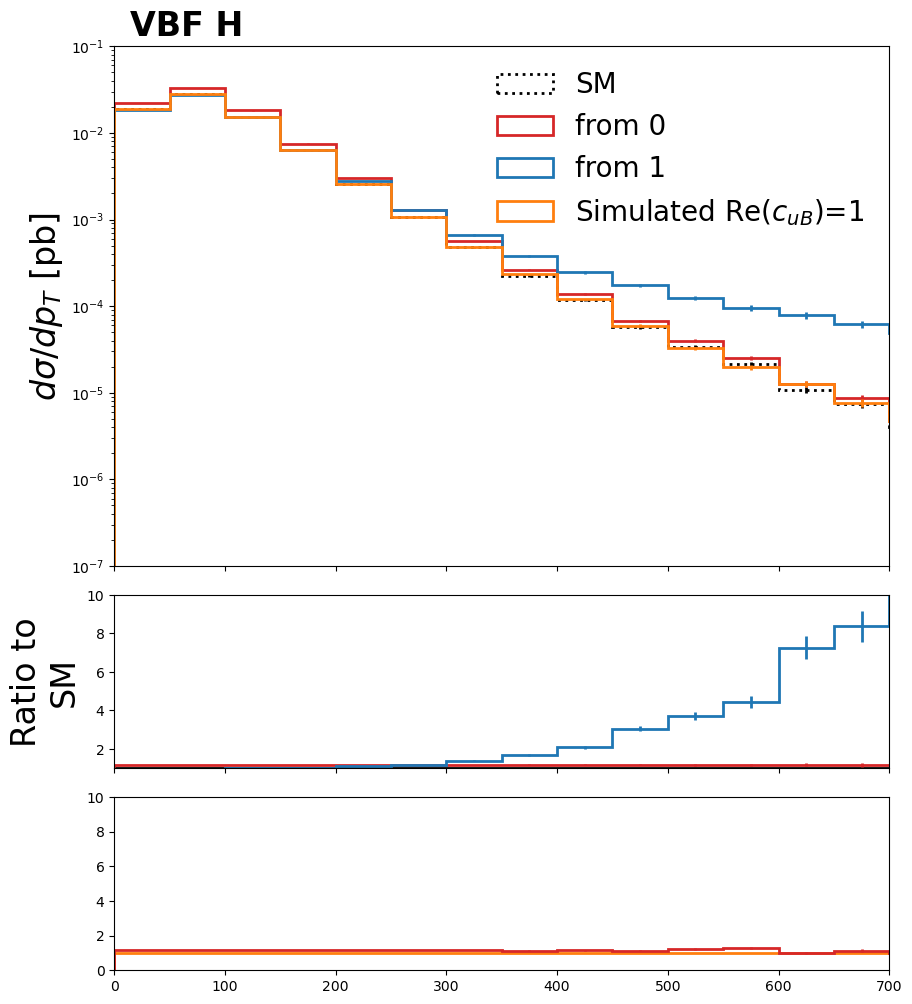

In [26]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuBRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuBRe', 1, name, h1, h2, d, rebin=10)

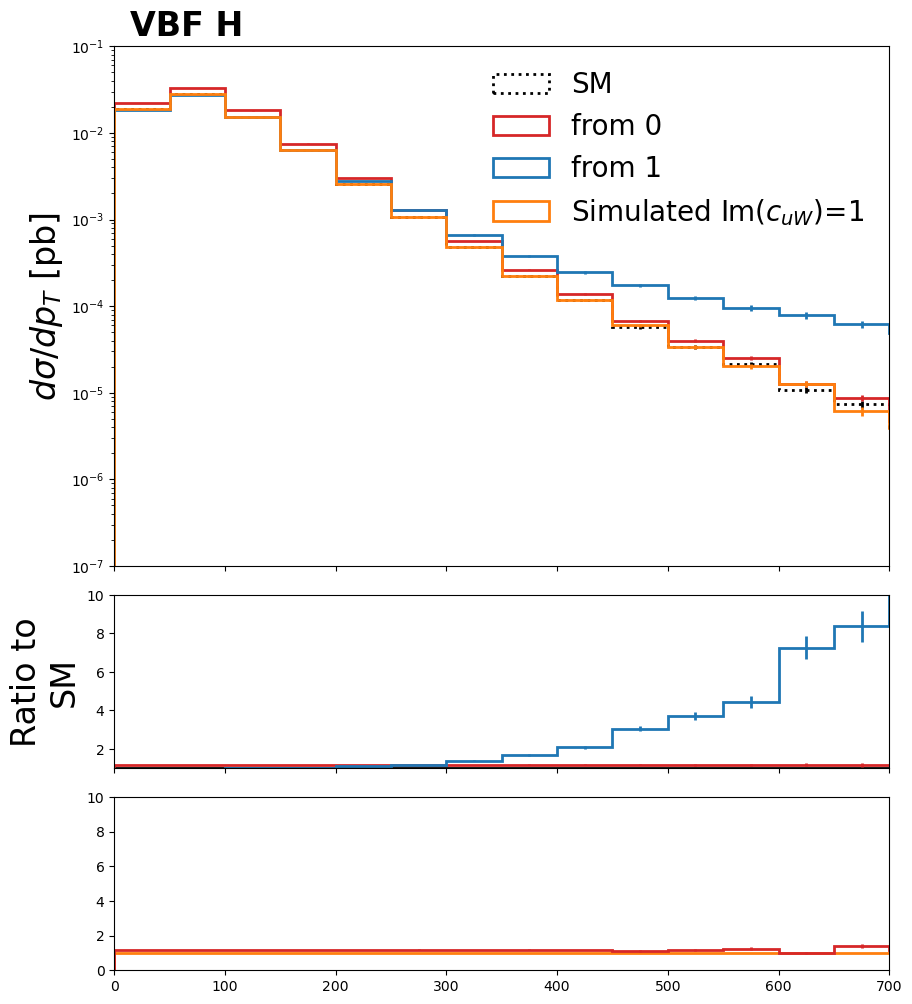

In [27]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuWIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuWIm', 1, name, h1, h2, d, rebin=10)

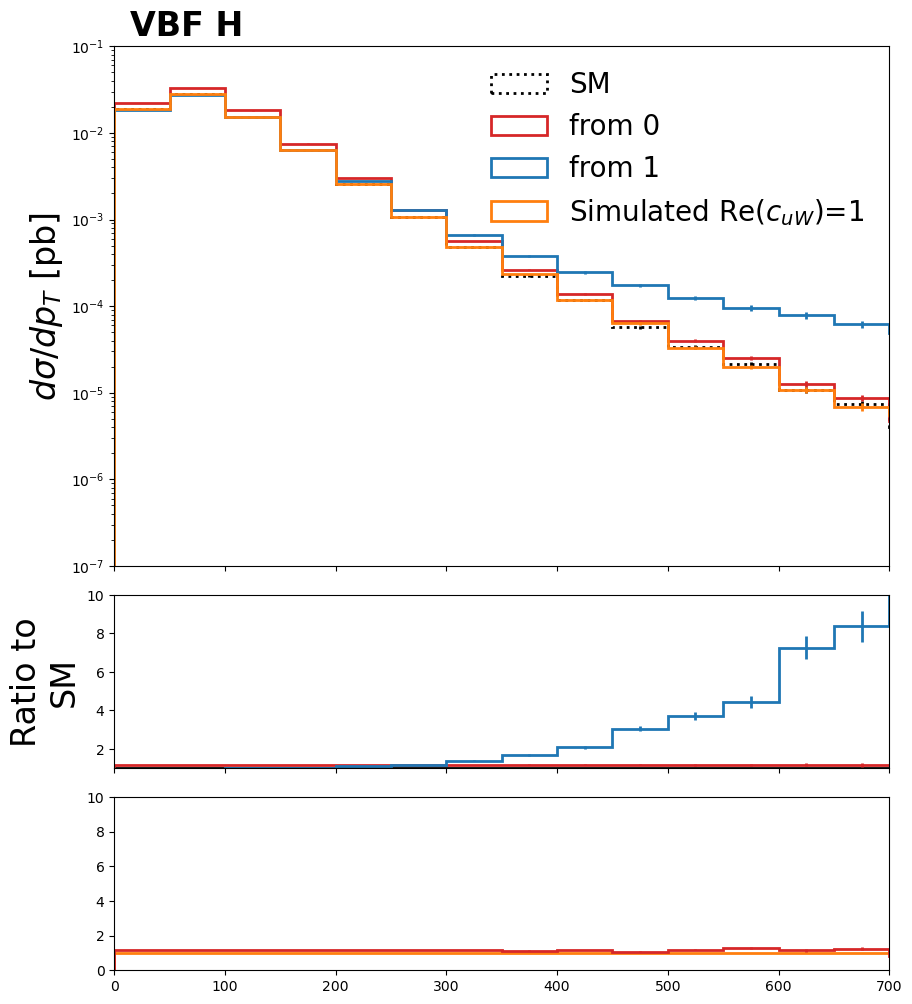

In [28]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuWRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuWRe', 1, name, h1, h2, d, rebin=10)